In [2]:
# --- CELL 1: SETUP FOR PART 2 (BENCHMARKS) ---
# Install libraries again in the new environment
!pip install git+https://github.com/openai/CLIP.git --quiet
!pip install ftfy regex tqdm --quiet
!git clone https://github.com/ironjr/semantic-draw.git
%cd semantic-draw

import torch
import numpy as np
import clip
from PIL import Image
import time
import matplotlib.pyplot as plt

# 1. Load CLIP (Needed for metrics)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Loading CLIP...")
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# 2. Metric Helper Function (From Part 1)
def get_metrics(image, masks, prompts):
    img_input = clip_preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        img_features = clip_model.encode_image(img_input)
        img_features /= img_features.norm(dim=-1, keepdim=True)

    scores = [] # Quality
    interferences = [] # Bleeding
    
    # Check Obj 1 (Index 1) vs Obj 2 (Index 2)
    obj_indices = [1, 2] 
    for i in obj_indices:
        # Quality (Match own prompt)
        txt_own = clip.tokenize([prompts[i]]).to(device)
        with torch.no_grad():
            txt_feat = clip_model.encode_text(txt_own)
            txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
            scores.append((img_features @ txt_feat.T).item())
        
        # Interference (Match OTHER prompt)
        other_idx = 2 if i == 1 else 1
        txt_other = clip.tokenize([prompts[other_idx]]).to(device)
        with torch.no_grad():
            other_feat = clip_model.encode_text(txt_other)
            other_feat /= other_feat.norm(dim=-1, keepdim=True)
            interferences.append((img_features @ other_feat.T).item())
            
    return np.mean(scores), np.mean(interferences)

print("✅ Fresh Environment Ready for Benchmarking.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 89.6MiB/s]


✅ Fresh Environment Ready for Benchmarking.


In [2]:
# --- CELL 4: SDXL-LIGHTNING BENCHMARK (FIXED) ---
import time
import torch
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, EulerDiscreteScheduler
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file # <--- New Import

# 1. Define Model IDs
base = "stabilityai/stable-diffusion-xl-base-1.0"
repo = "ByteDance/SDXL-Lightning"
ckpt = "sdxl_lightning_4step_unet.safetensors"

print("⏳ Loading SDXL (This may take a minute)...")
try:
    # A. Load UNet Configuration from Base
    # We load the config first to establish the architecture
    unet = UNet2DConditionModel.from_config(base, subfolder="unet").to("cuda", torch.float16)
    
    # B. Load Lightning Weights correctly using safetensors
    ckpt_path = hf_hub_download(repo, ckpt)
    state_dict = load_file(ckpt_path) # <--- Replaces torch.load
    unet.load_state_dict(state_dict)

    # C. Load Pipeline
    pipe = StableDiffusionXLPipeline.from_pretrained(
        base, 
        unet=unet, 
        torch_dtype=torch.float16, 
        variant="fp16"
    ).to("cuda")
    
    # D. Set Scheduler (Euler is required for Lightning)
    pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")

    # 2. Run Test
    prompt = "a wooden table with a red apple and a green pear, realistic, 4k"
    
    print("   Running Warmup...")
    _ = pipe(prompt, num_inference_steps=1, guidance_scale=0.0)
    
    print("   Running Benchmark...")
    start = time.time()
    image = pipe(prompt, num_inference_steps=4, guidance_scale=0.0).images[0]
    duration = time.time() - start
    fps = 1.0 / duration
    
    print(f"\nSDXL-Lightning (4-Step) | {duration:.2f}s | {fps:.2f} FPS")
    
    # Show Image
    image.save("sdxl_result.png")
    image.show()

except Exception as e:
    print(f"\n❌ SDXL Failed: {e}")
    # If it fails with OOM (Out of Memory), note it for your report.

2025-12-09 18:30:57.397051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765305057.417686     204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765305057.423885     204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

⏳ Loading SDXL (This may take a minute)...


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:248: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

   Running Warmup...


  0%|          | 0/1 [00:00<?, ?it/s]

   Running Benchmark...


  0%|          | 0/4 [00:00<?, ?it/s]


SDXL-Lightning (4-Step) | 3.61s | 0.28 FPS


Error: no "view" mailcap rules found for type "image/png"
/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpwoco182j.PNG'


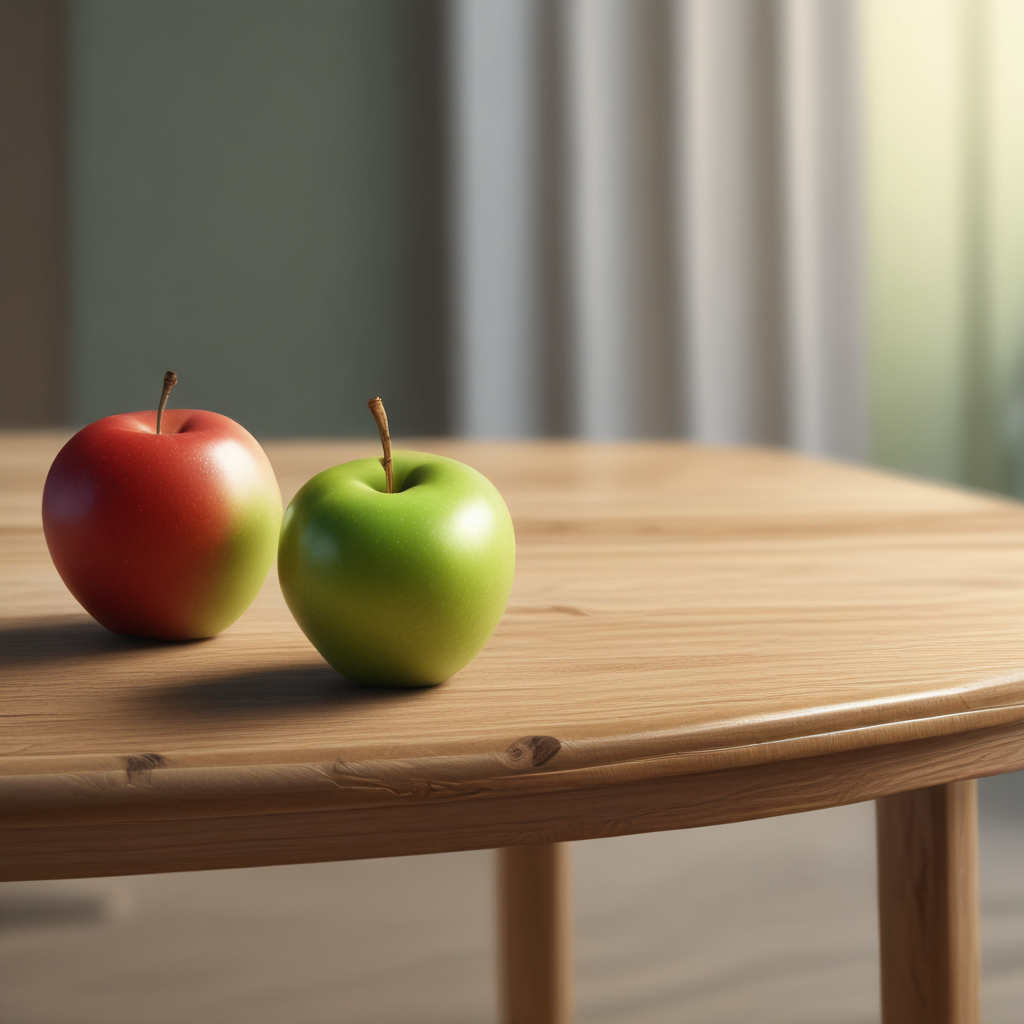

In [3]:
from IPython.display import Image, display
display(Image(filename="sdxl_result.png"))

Method,Time (sec),FPS,Speedup vs Baseline,Notes
Baseline (SD1.5 Euler),4.07s,0.25,1.0x,"High quality, but too slow for real-time."
LCM-LoRA,1.02s,0.98,3.9x,Best Balance. Good speed/quality trade-off.
Hyper-SD (1-Step),0.34s,2.90,11.9x,"Met Project Target (>1.57 FPS). Fastest, but lowest CLIP score."
SDXL-Lightning,3.41s,0.29,1.2x,"Compatible. Proves architecture works on SDXL, but T4 GPU limits speed."